In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Piauí - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_PI.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - Consumo de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego
0,2003-1,1.392136e+06,0.578335,0.572145,1002.090457,619.438209,29.774322,22.498674,65.288728,1.531145,0.730178,0.649218,9410.948400,24.669760,21.844,0.605431,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.192266
1,2003-2,1.402507e+06,0.578959,0.575756,1002.091633,621.987667,29.768728,22.492857,65.296204,1.530215,0.730506,0.649661,9501.490708,25.167145,15.814,0.605952,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.186156
2,2003-3,1.412879e+06,0.579583,0.577863,1002.092318,623.474852,29.765464,22.489463,65.300565,1.529673,0.730835,0.650104,9582.303300,25.520404,16.067,0.606473,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.180046
3,2003-4,1.423251e+06,0.580207,0.578089,1002.092392,623.634193,29.765115,22.489100,65.301032,1.529614,0.731163,0.650548,9659.062943,25.519725,14.938,0.606993,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.173937
4,2003-5,1.433623e+06,0.580831,0.565428,1001.931726,593.257336,29.985428,22.815550,65.747286,1.500524,0.731492,0.650991,9730.815357,25.929312,17.765,0.607514,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.167827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34695.529844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34658.823737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34607.295476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34536.949393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


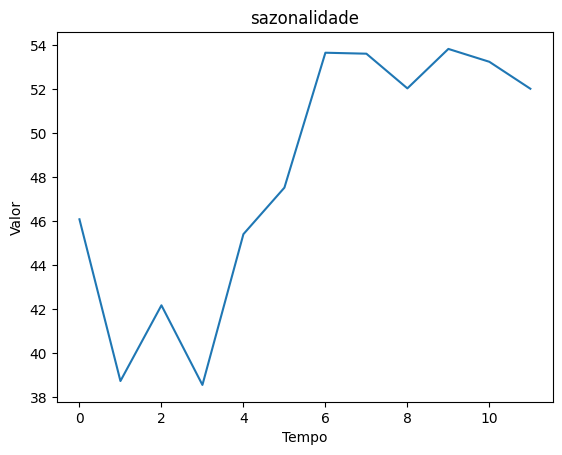

,sazonalidade
sazonalidade,
0,46.079897
1,38.738813
2,42.175584
3,38.561409
4,45.404639
5,47.516156
6,53.640458
7,53.596443
8,52.022448


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade,Piauí - Consumo de Cimento (t)
0,2003-1,1.392136e+06,0.578335,0.572145,1002.090457,619.438209,29.774322,22.498674,65.288728,1.531145,0.730178,0.649218,9410.948400,24.669760,0.605431,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.192266,46.079897,21.844
1,2003-2,1.402507e+06,0.578959,0.575756,1002.091633,621.987667,29.768728,22.492857,65.296204,1.530215,0.730506,0.649661,9501.490708,25.167145,0.605952,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.186156,38.738813,15.814
2,2003-3,1.412879e+06,0.579583,0.577863,1002.092318,623.474852,29.765464,22.489463,65.300565,1.529673,0.730835,0.650104,9582.303300,25.520404,0.606473,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.180046,42.175584,16.067
3,2003-4,1.423251e+06,0.580207,0.578089,1002.092392,623.634193,29.765115,22.489100,65.301032,1.529614,0.731163,0.650548,9659.062943,25.519725,0.606993,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.173937,38.561409,14.938
4,2003-5,1.433623e+06,0.580831,0.565428,1001.931726,593.257336,29.985428,22.815550,65.747286,1.500524,0.731492,0.650991,9730.815357,25.929312,0.607514,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.167827,45.404639,17.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34695.529844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.404639,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34658.823737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.516156,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34607.295476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.640458,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34536.949393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.596443,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      19.758
1      19.763
2      22.445
3      20.109
4      24.283
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Piauí - Consumo de Cimento (t), Length: 249, dtype: float64

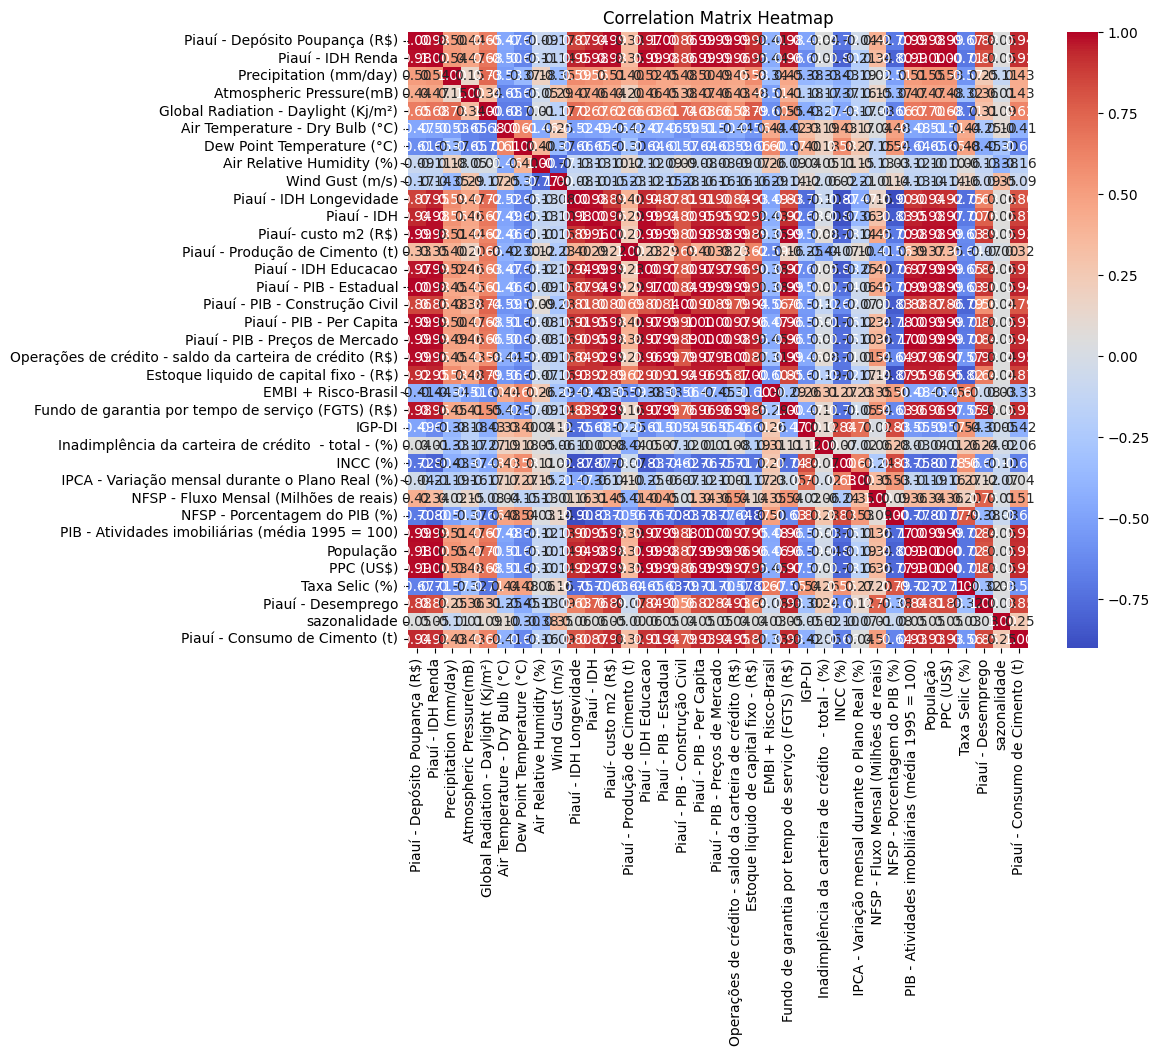

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Piauí - Depósito Poupança (R$),1.222968e+06
1,Piauí - IDH Renda,5.246203e+08
2,Precipitation (mm/day),4.394021e+01
3,Atmospheric Pressure(mB),1.235183e+07
4,Global Radiation - Daylight (Kj/m²),1.400490e+02
5,Air Temperature - Dry Bulb (°C),5.322387e+04
6,Dew Point Temperature (°C),1.491109e+04
7,Air Relative Humidity (%),1.232175e+04
8,Wind Gust (m/s),4.802969e+02
9,Piauí - IDH Longevidade,5.634723e+05


In [39]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade
0,1.392136e+06,0.578335,0.572145,1002.090457,619.438209,29.774322,22.498674,65.288728,1.531145,9410.948400,24.669760,0.605431,2.136063e+07,1.358044e+06,1.868149e+07,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.192266,46.079897
1,1.402507e+06,0.578959,0.575756,1002.091633,621.987667,29.768728,22.492857,65.296204,1.530215,9501.490708,25.167145,0.605952,2.139102e+07,1.359835e+06,1.869506e+07,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.186156,38.738813
2,1.412879e+06,0.579583,0.577863,1002.092318,623.474852,29.765464,22.489463,65.300565,1.529673,9582.303300,25.520404,0.606473,2.142142e+07,1.361626e+06,1.870864e+07,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.180046,42.175584
3,1.423251e+06,0.580207,0.578089,1002.092392,623.634193,29.765115,22.489100,65.301032,1.529614,9659.062943,25.519725,0.606993,2.145181e+07,1.363417e+06,1.872222e+07,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.173937,38.561409
4,1.433623e+06,0.580831,0.565428,1001.931726,593.257336,29.985428,22.815550,65.747286,1.500524,9730.815357,25.929312,0.607514,2.148221e+07,1.365208e+06,1.873580e+07,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.167827,45.404639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,3.833377e+06,0.649101,2.168705,1002.936767,1317.068922,28.556720,18.450277,58.240101,1.387073,23810.760312,21.765063,0.673619,2.657953e+07,1.434520e+06,2.022190e+07,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,11.093842,53.596443
176,3.844666e+06,0.649058,1.662168,1002.426561,1303.834661,28.900596,18.387538,56.753388,1.465325,23909.971713,21.232248,0.673681,2.657830e+07,1.434662e+06,2.022068e+07,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,11.082529,52.022448
177,3.855956e+06,0.649016,1.971911,1001.981246,1272.890973,28.898883,19.119555,59.029420,1.436549,24010.617620,20.784566,0.673743,2.657706e+07,1.434804e+06,2.021946e+07,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,11.071216,53.813113
178,3.867245e+06,0.648973,2.172339,1001.875297,1214.242172,28.632472,20.009430,62.793981,1.345743,24110.240760,20.341515,0.673805,2.657583e+07,1.434946e+06,2.021824e+07,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,1.989930e+08,419.430070,1.004174,11.059902,53.228741


In [40]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade
0,-2.008418,-0.770546,-0.067523,-0.865578,0.348874,0.307998,-0.222590,0.977615,-1.566632,-1.515936,-1.897770,-1.618874,-2.407469,-1.907224,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-0.678784,-0.354741
1,-1.978986,-0.766780,-0.066689,-0.860713,0.346518,0.305836,-0.221770,0.973740,-1.545973,-1.463332,-1.870720,-1.601515,-2.341664,-1.879787,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-0.683408,-1.666418
2,-1.949553,-0.764583,-0.066203,-0.857875,0.345144,0.304575,-0.221292,0.971480,-1.527534,-1.425971,-1.843670,-1.584156,-2.275858,-1.852350,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-0.688031,-1.052349
3,-1.920121,-0.764348,-0.066151,-0.857571,0.344997,0.304440,-0.221240,0.971238,-1.510019,-1.426043,-1.816620,-1.566797,-2.210052,-1.824914,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.692655,-1.698116
4,-1.890689,-0.777552,-0.180103,-0.915536,0.437764,0.425745,-0.172286,0.850041,-1.493647,-1.382725,-1.789569,-1.549438,-2.144247,-1.797477,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-0.697279,-0.475394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.329306,0.894622,0.532724,0.465629,-0.163821,-1.196329,-0.995829,0.377381,1.719003,-1.823137,1.644380,1.361835,0.402710,1.205548,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,1.517122,0.988287
176,1.327304,0.366318,0.170859,0.440376,-0.019025,-1.219642,-1.158922,0.703393,1.741640,-1.879487,1.647601,1.361131,0.407931,1.203085,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,1.508560,0.707052
177,1.325302,0.689371,-0.144981,0.381329,-0.019747,-0.947635,-0.909240,0.583510,1.764605,-1.926834,1.650823,1.360427,0.413151,1.200623,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,1.499999,1.027001
178,1.323301,0.898412,-0.220126,0.269417,-0.131924,-0.616970,-0.496266,0.205191,1.787336,-1.973691,1.654044,1.359723,0.418372,1.198160,1.365401,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,1.491437,0.922588


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade
0,-2.008418,-0.770546,-0.067523,-0.865578,0.348874,0.307998,-0.222590,0.977615,-1.566632,-1.515936,-1.897770,-1.618874,-2.407469,-1.907224,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-0.678784,-0.354741
1,-1.978986,-0.766780,-0.066689,-0.860713,0.346518,0.305836,-0.221770,0.973740,-1.545973,-1.463332,-1.870720,-1.601515,-2.341664,-1.879787,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-0.683408,-1.666418
2,-1.949553,-0.764583,-0.066203,-0.857875,0.345144,0.304575,-0.221292,0.971480,-1.527534,-1.425971,-1.843670,-1.584156,-2.275858,-1.852350,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-0.688031,-1.052349
3,-1.920121,-0.764348,-0.066151,-0.857571,0.344997,0.304440,-0.221240,0.971238,-1.510019,-1.426043,-1.816620,-1.566797,-2.210052,-1.824914,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.692655,-1.698116
4,-1.890689,-0.777552,-0.180103,-0.915536,0.437764,0.425745,-0.172286,0.850041,-1.493647,-1.382725,-1.789569,-1.549438,-2.144247,-1.797477,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-0.697279,-0.475394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.373784,0.164966,0.536975,0.458905,0.183976,-1.438054,-1.417143,0.668334,1.433460,-0.869815,1.565582,1.334620,0.364987,1.188039,1.407354,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,1.586760,0.988287
164,1.367691,0.306351,0.128816,0.426952,0.338798,-1.364943,-1.482468,0.960504,1.456359,-0.955645,1.576832,1.341049,0.365223,1.194988,1.402136,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,1.584819,0.707052
165,1.361598,0.155832,-0.182127,0.370577,0.288292,-1.214291,-1.299700,0.971598,1.480235,-1.042369,1.588082,1.347478,0.365459,1.201937,1.398719,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,1.582878,1.027001
166,1.355505,0.283117,-0.253570,0.273340,0.092837,-0.890997,-0.832683,0.668277,1.504970,-1.130009,1.599332,1.353907,0.365695,1.208887,1.393142,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,1.580938,0.922588


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      19.758
1      19.763
2      22.445
3      20.109
4      24.283
        ...  
163    63.141
164    55.580
165    60.001
166    62.767
167    45.308
Name: Piauí - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 29)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade
132,0.821283,1.026543,0.155307,0.190287,-0.726491,-0.106738,0.696879,-0.935484,0.783141,0.730865,0.651354,1.016528,1.295893,1.053163,0.992500,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.848407,0.878252,-0.590376,1.074473,-0.354741
133,0.812220,0.998893,0.258462,0.162850,-0.801142,0.070282,0.954097,-1.244611,0.804409,0.691743,0.656947,1.029004,1.248827,1.055063,1.013803,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.861179,0.887574,-0.476859,1.103260,-1.666418
134,0.803157,0.891296,0.523669,0.188015,-0.820499,0.102732,0.997893,-1.271300,0.825810,0.668829,0.662539,1.041481,1.201761,1.056963,1.036490,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.873950,0.896990,-0.089952,1.132047,-1.052349
135,0.794093,0.550156,0.922261,0.223220,-0.811704,-0.018120,0.857431,-1.209342,0.847296,0.645546,0.668132,1.053957,1.154696,1.058862,1.059637,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.886722,0.906245,-0.814200,1.160834,-1.698116
136,0.785030,0.071788,1.175740,0.348415,-0.744954,-0.318445,0.485109,-0.972680,0.869254,0.622279,0.673725,1.066434,1.107630,1.060762,1.080606,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.899493,0.915208,-0.917944,1.189622,-0.475394
137,0.775967,-0.223752,1.268162,0.563291,-0.596277,-0.646814,0.021985,-0.556678,0.890427,0.597882,0.679317,1.078910,1.060564,1.062661,1.101264,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.912265,0.924126,-0.708692,1.218409,-0.098116
138,0.766904,-0.248948,1.305395,0.805287,-0.371970,-0.909762,-0.464445,0.274649,0.910464,0.573763,0.684910,1.091387,1.013499,1.064561,1.123860,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.925036,0.932114,-0.496126,1.247196,0.996152
139,0.757841,-0.131588,0.943836,0.949596,-0.098918,-1.054267,-0.875074,0.855873,0.931196,0.549317,0.690502,1.103863,0.966433,1.066460,1.150086,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.937808,0.939863,-0.251065,1.275983,0.988287
140,0.748778,0.172825,0.628001,0.913021,0.072226,-1.037013,-1.034652,1.166773,0.951335,0.525057,0.696095,1.116340,0.919367,1.068360,1.179474,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.950580,0.947944,-0.593206,1.304770,0.707052
141,0.739714,0.116784,0.522974,0.800827,0.076148,-0.937021,-0.967906,1.239496,0.971285,0.500879,0.701688,1.128816,0.872302,1.070260,1.214576,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.963351,0.956229,-0.100794,1.333557,1.027001


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 29)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(108, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3200357660, 437022258, 2861596970, 2348910552, 1058803650, 1493903141, 2220645546, 3811783460, 595086915, 73689956]


Step: 0 ___________________________________________
val_loss: 401.3094787597656
winner_seed: 3200357660


Step: 1 ___________________________________________
val_loss: 307.5856018066406
winner_seed: 437022258


Step: 2 ___________________________________________
val_loss: 555.3961181640625


Step: 3 ___________________________________________
val_loss: 113.19983673095703
winner_seed: 2348910552


Step: 4 ___________________________________________
val_loss: 454.0027160644531


Step: 5 ___________________________________________
val_loss: 307.35595703125


Step: 6 ___________________________________________
val_loss: 241.45985412597656


Step: 7 ___________________________________________
val_loss: 475.7867126464844


Step: 8 ___________________________________________
val_loss: 156.16954040527344


Step: 9 ___________________________________________
val_loss: 395.96926

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2348910552

Epoch 1/10000
4/4 [==============================] - 2s 148ms/step - loss: 3035.4871 - val_loss: 134.9468
Epoch 2/10000
4/4 [==============================] - 0s 12ms/step - loss: 265.7990 - val_loss: 135.7717
Epoch 3/10000
4/4 [==============================] - 0s 13ms/step - loss: 247.5647 - val_loss: 154.3049
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 217.2506 - val_loss: 415.5955
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 211.1159 - val_loss: 283.0908
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 118.4639 - val_loss: 458.7538
Epoch 7/10000
4/4 [==============================] - 0s 12ms/step - loss: 110.1838 - val_loss: 296.0443
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 90.0062 - val_loss: 218.4568
Epoch 9/10000
4/4 [==============================] - 0s 12ms/step - loss: 148.8326 - val_loss: 339.4386
Epoch 10/10000
4/4 [==============================] - 0s 12ms/s

Epoch 80/10000
4/4 [==============================] - 0s 13ms/step - loss: 20.9187 - val_loss: 393.3947
Epoch 81/10000
4/4 [==============================] - 0s 12ms/step - loss: 29.0859 - val_loss: 587.6339
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.6222 - val_loss: 587.3495
Epoch 83/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.2706 - val_loss: 565.2274
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.0378 - val_loss: 700.9838
Epoch 85/10000
4/4 [==============================] - 0s 12ms/step - loss: 23.3280 - val_loss: 534.2689
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.1881 - val_loss: 646.4476
Epoch 87/10000
4/4 [==============================] - 0s 11ms/step - loss: 27.1859 - val_loss: 713.2820
Epoch 88/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.8841 - val_loss: 471.7644
Epoch 89/10000
4/4 [==============================] - 0s 11ms/st

4/4 [==============================] - 0s 13ms/step - loss: 16.4869 - val_loss: 746.3072
Epoch 237/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.0460 - val_loss: 687.1403
Epoch 238/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.1724 - val_loss: 621.3174
Epoch 239/10000
4/4 [==============================] - 0s 13ms/step - loss: 16.8872 - val_loss: 654.4753
Epoch 240/10000
4/4 [==============================] - 0s 14ms/step - loss: 15.0596 - val_loss: 760.4944
Epoch 241/10000
4/4 [==============================] - 0s 14ms/step - loss: 13.9437 - val_loss: 734.1539
Epoch 242/10000
4/4 [==============================] - 0s 13ms/step - loss: 16.8799 - val_loss: 717.0347
Epoch 243/10000
4/4 [==============================] - 0s 13ms/step - loss: 16.0816 - val_loss: 583.6141
Epoch 244/10000
4/4 [==============================] - 0s 13ms/step - loss: 24.4458 - val_loss: 649.1225
Epoch 245/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 12.3451 - val_loss: 703.5100
Epoch 393/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.5885 - val_loss: 804.1907
Epoch 394/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.6170 - val_loss: 619.4036
Epoch 395/10000
4/4 [==============================] - 0s 13ms/step - loss: 12.3373 - val_loss: 691.6720
Epoch 396/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.8888 - val_loss: 693.0215
Epoch 397/10000
4/4 [==============================] - 0s 14ms/step - loss: 13.2556 - val_loss: 634.7562
Epoch 398/10000
4/4 [==============================] - 0s 13ms/step - loss: 12.8172 - val_loss: 760.7440
Epoch 399/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.1728 - val_loss: 762.6135
Epoch 400/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.8835 - val_loss: 649.8629
Epoch 401/10000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 9.3736 - val_loss: 654.3173
Epoch 549/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.4300 - val_loss: 709.2337
Epoch 550/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.4529 - val_loss: 699.8883
Epoch 551/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.1146 - val_loss: 660.0745
Epoch 552/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.1639 - val_loss: 668.7678
Epoch 553/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.4533 - val_loss: 683.4478
Epoch 554/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.8943 - val_loss: 746.4293
Epoch 555/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.2562 - val_loss: 693.0442
Epoch 556/10000
4/4 [==============================] - 0s 13ms/step - loss: 12.9105 - val_loss: 775.3898
Epoch 557/10000
4/4 [==============================] - 0s 12ms/step - lo

4/4 [==============================] - 0s 11ms/step - loss: 9.9975 - val_loss: 664.7971
Epoch 705/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.4549 - val_loss: 671.7017
Epoch 706/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.7025 - val_loss: 648.1311
Epoch 707/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.1153 - val_loss: 714.5764
Epoch 708/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.2538 - val_loss: 673.8990
Epoch 709/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.9789 - val_loss: 671.8064
Epoch 710/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.8916 - val_loss: 748.6596
Epoch 711/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.6510 - val_loss: 787.1116
Epoch 712/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.5069 - val_loss: 718.2000
Epoch 713/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.3

Epoch 783/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.3552 - val_loss: 701.7558
Epoch 784/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.1903 - val_loss: 653.4052
Epoch 785/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.4459 - val_loss: 687.1005
Epoch 786/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.4092 - val_loss: 676.3805
Epoch 787/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.7119 - val_loss: 616.0729
Epoch 788/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.3864 - val_loss: 680.2911
Epoch 789/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.9647 - val_loss: 722.6425
Epoch 790/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.7022 - val_loss: 710.2261
Epoch 791/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.5512 - val_loss: 650.7720
Epoch 792/10000
4/4 [==============================] - 0s 11ms/

Epoch 940/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.3996 - val_loss: 672.0063
Epoch 941/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.3070 - val_loss: 615.7914
Epoch 942/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6795 - val_loss: 693.7749
Epoch 943/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1473 - val_loss: 551.7729
Epoch 944/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1093 - val_loss: 684.4926
Epoch 945/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.8062 - val_loss: 592.7484
Epoch 946/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1804 - val_loss: 649.9203
Epoch 947/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.7634 - val_loss: 666.1946
Epoch 948/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.9953 - val_loss: 643.4684
Epoch 949/10000
4/4 [==============================] - 0s 11ms/

4/4 [==============================] - 0s 12ms/step - loss: 6.8298 - val_loss: 632.6247
Epoch 1097/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.3928 - val_loss: 655.1243
Epoch 1098/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.4796 - val_loss: 655.6495
Epoch 1099/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8732 - val_loss: 563.6396
Epoch 1100/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.1801 - val_loss: 583.3976
Epoch 1101/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.2691 - val_loss: 611.4130
Epoch 1102/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.4868 - val_loss: 646.8432
Epoch 1103/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8514 - val_loss: 586.4561
Epoch 1104/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.2593 - val_loss: 674.2505
Epoch 1105/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 7.2542 - val_loss: 611.2703
Epoch 1253/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.9226 - val_loss: 620.2222
Epoch 1254/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.0154 - val_loss: 682.8060
Epoch 1255/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.8478 - val_loss: 537.7026
Epoch 1256/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.7104 - val_loss: 600.3550
Epoch 1257/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.5281 - val_loss: 662.4310
Epoch 1258/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.3327 - val_loss: 603.7623
Epoch 1259/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.8010 - val_loss: 610.0139
Epoch 1260/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.9966 - val_loss: 613.6547
Epoch 1261/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 5.8961 - val_loss: 594.0619
Epoch 1409/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.2765 - val_loss: 545.2394
Epoch 1410/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.2365 - val_loss: 606.8210
Epoch 1411/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.0301 - val_loss: 587.6614
Epoch 1412/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.6426 - val_loss: 553.1978
Epoch 1413/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.8428 - val_loss: 602.4464
Epoch 1414/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.0929 - val_loss: 578.0589
Epoch 1415/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.7804 - val_loss: 522.7049
Epoch 1416/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.2241 - val_loss: 551.1188
Epoch 1417/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 6.0624 - val_loss: 560.0502
Epoch 1565/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.7600 - val_loss: 649.4886
Epoch 1566/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2626 - val_loss: 616.7066
Epoch 1567/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2604 - val_loss: 529.0918
Epoch 1568/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.8711 - val_loss: 589.8196
Epoch 1569/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.9877 - val_loss: 577.6161
Epoch 1570/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7949 - val_loss: 538.5193
Epoch 1571/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.6970 - val_loss: 548.7292
Epoch 1572/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.2498 - val_loss: 584.2037
Epoch 1573/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 5.0823 - val_loss: 552.4266
Epoch 1721/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.9677 - val_loss: 546.6813
Epoch 1722/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2565 - val_loss: 547.0348
Epoch 1723/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2555 - val_loss: 539.3597
Epoch 1724/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2905 - val_loss: 560.5325
Epoch 1725/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.8071 - val_loss: 504.2240
Epoch 1726/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.4665 - val_loss: 583.6244
Epoch 1727/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.4962 - val_loss: 549.2490
Epoch 1728/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.2462 - val_loss: 534.4438
Epoch 1729/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 6.0611 - val_loss: 544.0191
Epoch 1877/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.6814 - val_loss: 545.2461
Epoch 1878/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.2865 - val_loss: 599.2646
Epoch 1879/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.5984 - val_loss: 577.2606
Epoch 1880/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.1780 - val_loss: 515.9164
Epoch 1881/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4954 - val_loss: 515.1926
Epoch 1882/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7617 - val_loss: 570.7930
Epoch 1883/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5377 - val_loss: 544.7552
Epoch 1884/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.3663 - val_loss: 523.7686
Epoch 1885/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 10ms/step - loss: 5.4834 - val_loss: 411.1033
Epoch 2033/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2436 - val_loss: 523.3490
Epoch 2034/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.0285 - val_loss: 509.9014
Epoch 2035/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5275 - val_loss: 517.4526
Epoch 2036/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7263 - val_loss: 564.1486
Epoch 2037/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.3999 - val_loss: 522.2597
Epoch 2038/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2134 - val_loss: 582.4823
Epoch 2039/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.2806 - val_loss: 594.2617
Epoch 2040/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.0497 - val_loss: 569.9870
Epoch 2041/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 3.6406 - val_loss: 546.1754
Epoch 2189/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.9687 - val_loss: 497.8376
Epoch 2190/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2208 - val_loss: 573.3854
Epoch 2191/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.2137 - val_loss: 497.1663
Epoch 2192/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8393 - val_loss: 487.6134
Epoch 2193/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.4836 - val_loss: 539.1880
Epoch 2194/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.4471 - val_loss: 475.0362
Epoch 2195/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4895 - val_loss: 559.5780
Epoch 2196/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2295 - val_loss: 523.1369
Epoch 2197/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 3.8637 - val_loss: 552.2282
Epoch 2345/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.9316 - val_loss: 401.7468
Epoch 2346/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.4822 - val_loss: 389.2699
Epoch 2347/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8379 - val_loss: 510.0984
Epoch 2348/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.7561 - val_loss: 396.9410
Epoch 2349/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.6728 - val_loss: 508.3951
Epoch 2350/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7779 - val_loss: 531.4711
Epoch 2351/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.1782 - val_loss: 495.7318
Epoch 2352/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.8759 - val_loss: 497.3727
Epoch 2353/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 3.7259 - val_loss: 528.5376
Epoch 2501/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.5058 - val_loss: 521.1387
Epoch 2502/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.1407 - val_loss: 559.1474
Epoch 2503/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.2700 - val_loss: 528.7173
Epoch 2504/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4648 - val_loss: 422.1962
Epoch 2505/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.7087 - val_loss: 448.9065
Epoch 2506/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.6524 - val_loss: 548.2227
Epoch 2507/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6518 - val_loss: 430.6765
Epoch 2508/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8003 - val_loss: 488.3900
Epoch 2509/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 4.0855 - val_loss: 599.6473
Epoch 2579/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2853 - val_loss: 613.2472
Epoch 2580/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.3202 - val_loss: 580.4740
Epoch 2581/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.9232 - val_loss: 611.0613
Epoch 2582/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7453 - val_loss: 562.2437
Epoch 2583/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.1125 - val_loss: 574.0798
Epoch 2584/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8609 - val_loss: 558.3274
Epoch 2585/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.0950 - val_loss: 561.7854
Epoch 2586/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.3130 - val_loss: 571.8393
Epoch 2587/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 3.9263 - val_loss: 544.6400
Epoch 2735/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3318 - val_loss: 535.9709
Epoch 2736/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.5223 - val_loss: 513.9245
Epoch 2737/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2084 - val_loss: 538.0245
Epoch 2738/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3819 - val_loss: 545.3226
Epoch 2739/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4400 - val_loss: 585.3180
Epoch 2740/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.7785 - val_loss: 565.9844
Epoch 2741/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5687 - val_loss: 529.7786
Epoch 2742/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.6045 - val_loss: 480.3633
Epoch 2743/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 2.7371 - val_loss: 558.2726
Epoch 2891/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.9441 - val_loss: 507.5485
Epoch 2892/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.1380 - val_loss: 532.6955
Epoch 2893/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.5622 - val_loss: 526.7772
Epoch 2894/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.0414 - val_loss: 492.3982
Epoch 2895/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.1501 - val_loss: 508.2785
Epoch 2896/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.4561 - val_loss: 502.5281
Epoch 2897/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3229 - val_loss: 538.3571
Epoch 2898/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.6522 - val_loss: 535.9030
Epoch 2899/10000
4/4 [==============================] - 0s 11ms/step - l

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,61.189865,58.017998,49.833321,49.196072,57.345562,58.76651,64.472221,68.551399,70.509911,70.080269,68.686165,66.57473
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,4.047867,11.734997,6.443321,8.37207,2.282562,2.292511,3.660782,0.090599,5.768913,1.188728,1.055168,3.729729


In [54]:
display(mae)
display(mape)

4.2222705

0.08298308

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[743.224]] - Target[702.437]| =  Error: [[40.786987]]; MAPE:[[0.05806497]]


[array([[40.786987]], dtype=float32)]

40.786987

0.058064975